In [4]:
import os
import sys

print(f"####"*50)
ROOT="/home/alabutaleb/Desktop/myprojects/debugging_mvp"
sys.path.append(f"{ROOT}/src")
print(f"{sys.path=}")
print(f"{os.getcwd()=}")
print(f"####"*50)

import torch
import torch.nn as nn
import torch.nn.init as init

from datetime import datetime
import yaml
from loaders.cub200loader import DataLoaderCUB200
from datasets.cub200 import Cub2011

import matplotlib.pyplot as plt
import numpy as np
import random

# for debugging
from torch.utils.data import Subset

########################################################################################################################################################################################################
sys.path=['/home/alabutaleb/Desktop/myprojects/debugging_mvp/src/notebooks', '/home/alabutaleb/miniconda3/lib/python311.zip', '/home/alabutaleb/miniconda3/lib/python3.11', '/home/alabutaleb/miniconda3/lib/python3.11/lib-dynload', '', '/home/alabutaleb/Desktop/myprojects/debugging_mvp/env/lib/python3.11/site-packages', '/home/alabutaleb/Desktop/myprojects/debugging_mvp/src', '/home/alabutaleb/Desktop/myprojects/debugging_mvp/src', '/home/alabutaleb/Desktop/myprojects/debugging_mvp/src']
os.getcwd()='/home/alabutaleb/Desktop/myprojects/debugging_mvp/src/notebooks'
########################################################################################################################################################################################################


In [5]:

import numpy as np
import torch
from torchmetrics.retrieval import RetrievalMAP, RetrievalRecall


def calculate_map_torchmetrics(similarity_matrix, sorted_similarity_matrix, sorted_indices, gallery_labels, query_labels):
    # Assertions to ensure input validity
    assert isinstance(similarity_matrix, torch.Tensor), "similarity_matrix must be a torch.Tensor"
    assert isinstance(sorted_similarity_matrix, torch.Tensor), "sorted_similarity_matrix must be a torch.Tensor"
    assert isinstance(gallery_labels, torch.Tensor), "gallery_labels must be a torch.Tensor"
    assert isinstance(query_labels, torch.Tensor), "query_labels must be a torch.Tensor"
    assert similarity_matrix.dim() == 2, "similarity_matrix must be a 2D tensor"
    assert sorted_similarity_matrix.dim() == 2, "sorted_similarity_matrix must be a 2D tensor"
    assert similarity_matrix.shape == sorted_similarity_matrix.shape, "similarity_matrix and sorted_similarity_matrix must have the same shape"
    try:
        num_queries = similarity_matrix.shape[0]
        num_gallery_items = similarity_matrix.shape[1]

        # Prepare the indexes tensor. Each query gets a unique index.
        indexes = torch.arange(num_queries).unsqueeze(1).expand(-1, num_gallery_items)

        # Create binary ground truth tensor for each query-gallery pair
        expanded_query_labels = query_labels.unsqueeze(1).expand(-1, num_gallery_items)  # Reshape for broadcasting
        expanded_gallery_labels = gallery_labels.unsqueeze(0).expand(num_queries, -1)  # Reshape for broadcasting
        # ground_truths = (query_labels == gallery_labels).int()
        ground_truths = (expanded_query_labels == expanded_gallery_labels).int()

        print(f"####"*30)
        print(f"sum of the first row of ground truths: {ground_truths[0].sum()}")
        print(f"expanded_query_labels.shape: {expanded_query_labels.shape}")
        # print(f"First 10 elements of expanded_query_labels: {expanded_query_labels[:10]}")
        print(f"expanded_gallery_labels.shape: {expanded_gallery_labels.shape}")
        # print(f"First 10 elements of expanded_gallery_labels: {expanded_gallery_labels[:10]}")
        print(f"ground_truths.shape: {ground_truths.shape}")
        print(f"First 10 elements of ground_truths: {ground_truths[:10][0]}")
        print(f"sorted_similarity_matrix.shape: {sorted_similarity_matrix.shape}")
        # print(f"First 10 elements of sorted_similarity_matrix: {sorted_similarity_matrix[:10]}")
        print(f"sorted_indices.shape: {sorted_indices.shape}")
        print(f"indexes.shape: {indexes.shape}")
        # print(f"First 10 elements of indexes: {indexes[:10]}")
        print(f"####"*30)

        # Initialize the RetrievalMAP metric
        retrieval_map_metric = RetrievalMAP()

        # Calculate mAP
        # map_score = retrieval_map_metric(sorted_similarity_matrix, ground_truths, indexes)#.compute()
        map_score = retrieval_map_metric(sorted_similarity_matrix, ground_truths, sorted_indices)#.compute()

        return map_score
        
    except Exception as e:
        raise RuntimeError("Error in computing mAP: " + str(e))

def calculate_recall_at_k(similarity_matrix, sorted_similarity_matrix, sorted_indices, gallery_labels, query_labels, k):
    # Validate inputs
    assert isinstance(similarity_matrix, torch.Tensor), "similarity_matrix must be a torch.Tensor"
    assert isinstance(sorted_similarity_matrix, torch.Tensor), "sorted_similarity_matrix must be a torch.Tensor"
    assert isinstance(sorted_indices, torch.Tensor), "sorted_indices must be a torch.Tensor"
    assert isinstance(gallery_labels, torch.Tensor), "gallery_labels must be a torch.Tensor"
    assert isinstance(query_labels, torch.Tensor), "query_labels must be a torch.Tensor"
    assert len(similarity_matrix.shape) == 2, "similarity_matrix must be a 2D tensor"
    assert similarity_matrix.shape == sorted_similarity_matrix.shape, "similarity_matrix and sorted_similarity_matrix must have the same shape"
    assert k > 0, "k must be a positive integer"
    try:
        # Number of queries and gallery items
        num_queries = similarity_matrix.shape[0]
        num_gallery_items = similarity_matrix.shape[1]

        # Prepare the indexes tensor
        indexes = torch.arange(num_queries).unsqueeze(1).expand(-1, num_gallery_items)

        # Create binary ground truth tensor for each query-gallery pair
        query_labels_expanded = query_labels.unsqueeze(1).expand(-1, num_gallery_items)  # Reshape for broadcasting
        gallery_labels_expanded = gallery_labels.unsqueeze(0).expand(num_queries, -1)  # Reshape for broadcasting
        ground_truths = (query_labels_expanded == gallery_labels_expanded).int()

        # Initialize the RetrievalRecall metric with top_k
        retrieval_recall_metric = RetrievalRecall(top_k=k)

        # Calculate Recall at K
        recall_at_k = retrieval_recall_metric(sorted_similarity_matrix, ground_truths, indexes)#.compute()
        recall_at_k = retrieval_recall_metric(sorted_similarity_matrix, ground_truths, sorted_indices)#.compute()

        return recall_at_k

    except Exception as e:
        raise RuntimeError(f"Error in calculate_recall_at_k: {e}")


def calculate_map_single_query(similarity_vector, sorted_similarity_vector, sorted_indices, gallery_labels, query_label):
    # Assertions to ensure input validity
    assert isinstance(similarity_vector, torch.Tensor), "similarity_vector must be a torch.Tensor"
    assert isinstance(sorted_similarity_vector, torch.Tensor), "sorted_similarity_vector must be a torch.Tensor"
    assert isinstance(gallery_labels, torch.Tensor), "gallery_labels must be a torch.Tensor"
    assert isinstance(query_label, (int, float, torch.Tensor)), "query_label must be an int, float, or a torch.Tensor"
    assert similarity_vector.dim() == 1, "similarity_vector must be a 1D tensor"
    assert sorted_similarity_vector.dim() == 1, "sorted_similarity_vector must be a 1D tensor"
    assert similarity_vector.shape == sorted_similarity_vector.shape, "similarity_vector and sorted_similarity_vector must have the same shape"

    # Convert query_label to int if it's a tensor
    if isinstance(query_label, torch.Tensor):
        assert query_label.numel() == 1, "query_label tensor must have a single element"
        query_label = query_label.item()

    try:
        num_gallery_items = similarity_vector.shape[0]

        indexes = torch.zeros(num_gallery_items, dtype=torch.long)
        ground_truths = (gallery_labels == query_label).int()

        retrieval_map_metric = RetrievalMAP()

        map_score = retrieval_map_metric(sorted_similarity_vector, ground_truths, indexes)#.compute
        # map_score = retrieval_map_metric(sorted_similarity_vector, ground_truths, sorted_indices)
        return map_score

    except Exception as e:
        raise RuntimeError("Error in computing mAP for single query: " + str(e))


def calculate_recall_at_k_single_query(single_query_similarity, gallery_labels, sorted_indices, query_label, k):
    # Validate inputs
    assert isinstance(single_query_similarity, torch.Tensor), "single_query_similarity must be a torch.Tensor"
    assert isinstance(gallery_labels, torch.Tensor), "gallery_labels must be a torch.Tensor"
    assert isinstance(query_label, (int, torch.Tensor)), "query_label must be an int or a torch.Tensor"
    assert single_query_similarity.dim() == 1, "single_query_similarity must be a 1D tensor"
    assert gallery_labels.dim() == 1, "gallery_labels must be a 1D tensor"
    assert k > 0, "k must be a positive integer"

    try:
        # Number of gallery items
        num_gallery_items = single_query_similarity.shape[0]

        # Since we have only one query, indexes will be all zeros
        indexes = torch.zeros(num_gallery_items, dtype=torch.long)

        # Create binary ground truth tensor for the query-gallery pairs
        ground_truths = (gallery_labels == query_label).int()

        # Initialize the RetrievalRecall metric with top_k
        retrieval_recall_metric = RetrievalRecall(top_k=k)

        # Calculate Recall at K for the single query
        recall_at_k = retrieval_recall_metric(single_query_similarity, ground_truths, indexes)#.compute()
        # recall_at_k = retrieval_recall_metric(single_query_similarity, ground_truths, sorted_indices)#.compute()

        return recall_at_k

    except Exception as e:
        raise RuntimeError(f"Error in calculate_recall_at_k_single_query: {e}")





def average_precision(retrieved, relevant):
    """
    Calculate Average Precision for a single query.
    :param retrieved: List of retrieved item indices.
    :param relevant: List of relevant item indices.
    :return: Average Precision score.
    """
    retrieved = np.array(retrieved)
    relevant = np.array(relevant)
    rel_mask = np.in1d(retrieved, relevant)

    cum_rel = np.cumsum(rel_mask)
    precision_at_k = cum_rel / (np.arange(len(retrieved)) + 1)
    average_precision = np.sum(precision_at_k * rel_mask) / len(relevant)
    
    return average_precision

def mean_average_precision(retrieved_lists, relevant_lists):
    """
    Calculate Mean Average Precision (mAP) for a set of queries.
    :param retrieved_lists: List of lists, each containing retrieved item indices for a query.
    :param relevant_lists: List of lists, each containing relevant item indices for a query.
    :return: Mean Average Precision score.
    """
    ap_scores = [average_precision(retrieved, relevant)
                 for retrieved, relevant in zip(retrieved_lists, relevant_lists)]
    
    return np.mean(ap_scores)


    # mean_average_precision(formatted_all_retrieved_indices, formatted_all_relevant_indices)



def mean_recall_at_k(predictions, retrieval_solution, k):
    """Computes mean recall at K for retrieval prediction.
    Args:
        predictions: Dict mapping test image ID to a list of strings corresponding
            to index image IDs.
        retrieval_solution: Dict mapping test image ID to list of ground-truth image
            IDs.
        k: The number of top predictions to consider for calculating recall.
    Returns:
        mean_recall: Mean recall at K score (float).
    Raises:
        ValueError: If a test image in `predictions` is not included in
            `retrieval_solution`.
    """
    num_test_images = len(retrieval_solution.keys())
    total_recall = 0.0

    for key, prediction in predictions.items():
        if key not in retrieval_solution:
            raise ValueError('Test image %s is not part of retrieval_solution' % key)

        relevant_items = set(retrieval_solution[key])
        top_k_predictions = prediction[:k]
        num_relevant_at_k = len([pred for pred in top_k_predictions if pred in relevant_items])
        recall_at_k = num_relevant_at_k / len(relevant_items) if relevant_items else 0
        total_recall += recall_at_k

    mean_recall = total_recall / num_test_images
    
    return mean_recall


In [7]:
# Set seed for reproducibility
seed_value = 42  # can be any integer value
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
random.seed(seed_value)

#### set device #####
device = "cuda" if torch.cuda.is_available() else "cpu"
gpu_id = os.environ.get('CUDA_VISIBLE_DEVICES', '0')  # Default to '0' if not set
print(f"GPU ID: {gpu_id}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")
#####################
###### prep directories ######
data_root = "/media/alabutaleb/09d46f11-3ed1-40ce-9868-932a0133f8bb1/data/cub200"
load_dir_baseline = f"/home/alabutaleb/Desktop/confirmation/baselines_allsizes/weights"   
load_dir_vanilla = f"/home/alabutaleb/Desktop/confirmation"    # "resnet50_feature_size_vanilla_cub200_batchsize_256_lr_7e.pth"
dir_debug = "/home/alabutaleb/Desktop/confirmation/Retrieval_eval_baselines_experiment_gpu_0/debugging/from_new_repo"

# os.makedirs(dir_debug, exist_ok=True)
# ensure_directory_exists(dir_debug)

print(f"Vanilla weights will be loaded from: {load_dir_vanilla}")
print(f"Baseline weights will be loaded from: {load_dir_baseline}")
#####################
dataset_name = "cub200"

#####################
print("###"*30)
print(f"You are curently using {device} device")
print("###"*30)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
#### hyperparameters #####
batch_size  = 256
warmup_epochs=20 

lr=0.00007 # best for baseline experiments
weight_decay = 2e-05

# PARALLEL_MODE = True
PARALLEL_MODE = False
DEBUG_MODE = False
# DEBUG_MODE = True  # Set seed for reproducibility
seed_value = 42  # can be any integer value
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
random.seed(seed_value)


GPU ID: 0
Number of GPUs: 2
Current GPU: 0
Device name: NVIDIA RTX A5000
Vanilla weights will be loaded from: /home/alabutaleb/Desktop/confirmation
Baseline weights will be loaded from: /home/alabutaleb/Desktop/confirmation/baselines_allsizes/weights
##########################################################################################
You are curently using cuda device
##########################################################################################


In [11]:

#### set device #####
device = "cuda" if torch.cuda.is_available() else "cpu"
gpu_id = os.environ.get('CUDA_VISIBLE_DEVICES', '0')  # Default to '0' if not set
print(f"GPU ID: {gpu_id}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current GPU: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name()}")
#####################
###### prep directories ######
data_root = "/media/alabutaleb/09d46f11-3ed1-40ce-9868-932a0133f8bb1/data/cub200"
load_dir_baseline = f"/home/alabutaleb/Desktop/confirmation/baselines_allsizes/weights"   
load_dir_vanilla = f"/home/alabutaleb/Desktop/confirmation"    # "resnet50_feature_size_vanilla_cub200_batchsize_256_lr_7e.pth"
dir_debug = "/home/alabutaleb/Desktop/confirmation/Retrieval_eval_baselines_experiment_gpu_0/debugging/from_new_repo"

# os.makedirs(dir_debug, exist_ok=True)
# ensure_directory_exists(dir_debug)

print(f"Vanilla weights will be loaded from: {load_dir_vanilla}")
print(f"Baseline weights will be loaded from: {load_dir_baseline}")
#####################
dataset_name = "cub200"

#####################
print("###"*30)
print(f"You are curently using {device} device")
print("###"*30)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed_value)
#### hyperparameters #####
batch_size  = 256

# use_early_stopping=True
use_early_stopping=False


#### get data #####root, batch_size=32,num_workers=10   
dataloadercub200 = DataLoaderCUB200(data_root, batch_size=batch_size, num_workers=10)
_, testloader_cub200 = dataloadercub200.get_dataloaders()
testloader_cub200


GPU ID: 0
Number of GPUs: 2
Current GPU: 0
Device name: NVIDIA RTX A5000
Vanilla weights will be loaded from: /home/alabutaleb/Desktop/confirmation
Baseline weights will be loaded from: /home/alabutaleb/Desktop/confirmation/baselines_allsizes/weights
##########################################################################################
You are curently using cuda device
##########################################################################################


In [12]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)
model.fc=nn.Identity()



/home/alabutaleb/Desktop/myprojects/debugging_mvp/env/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alabutaleb/Desktop/myprojects/debugging_mvp/env/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
from tqdm import tqdm
model.to(device)
model.requires_grad_(False).eval()
def get_features_labels(model,loader):
    features,labels = [],[]
    for x,y in tqdm(loader):
        x = x.to(device)
        y = y.to(device)
        features.append(model(x).detach().cpu())
        labels.append(y.detach().cpu())
    features = torch.cat(features)
    labels = torch.cat(labels)
    return features,labels

query, label = get_features_labels(model,testloader_cub200)

100%|██████████| 23/23 [00:08<00:00,  2.58it/s]


In [36]:
label = label.cpu()
query = query.cpu()

In [42]:
query = torch.tensor(
    [[1,0],[0,1],[1,1],
     [-1,-1],[-1,0],[0,-1]]).float()
label = torch.tensor([1,1,1,0,0,0])

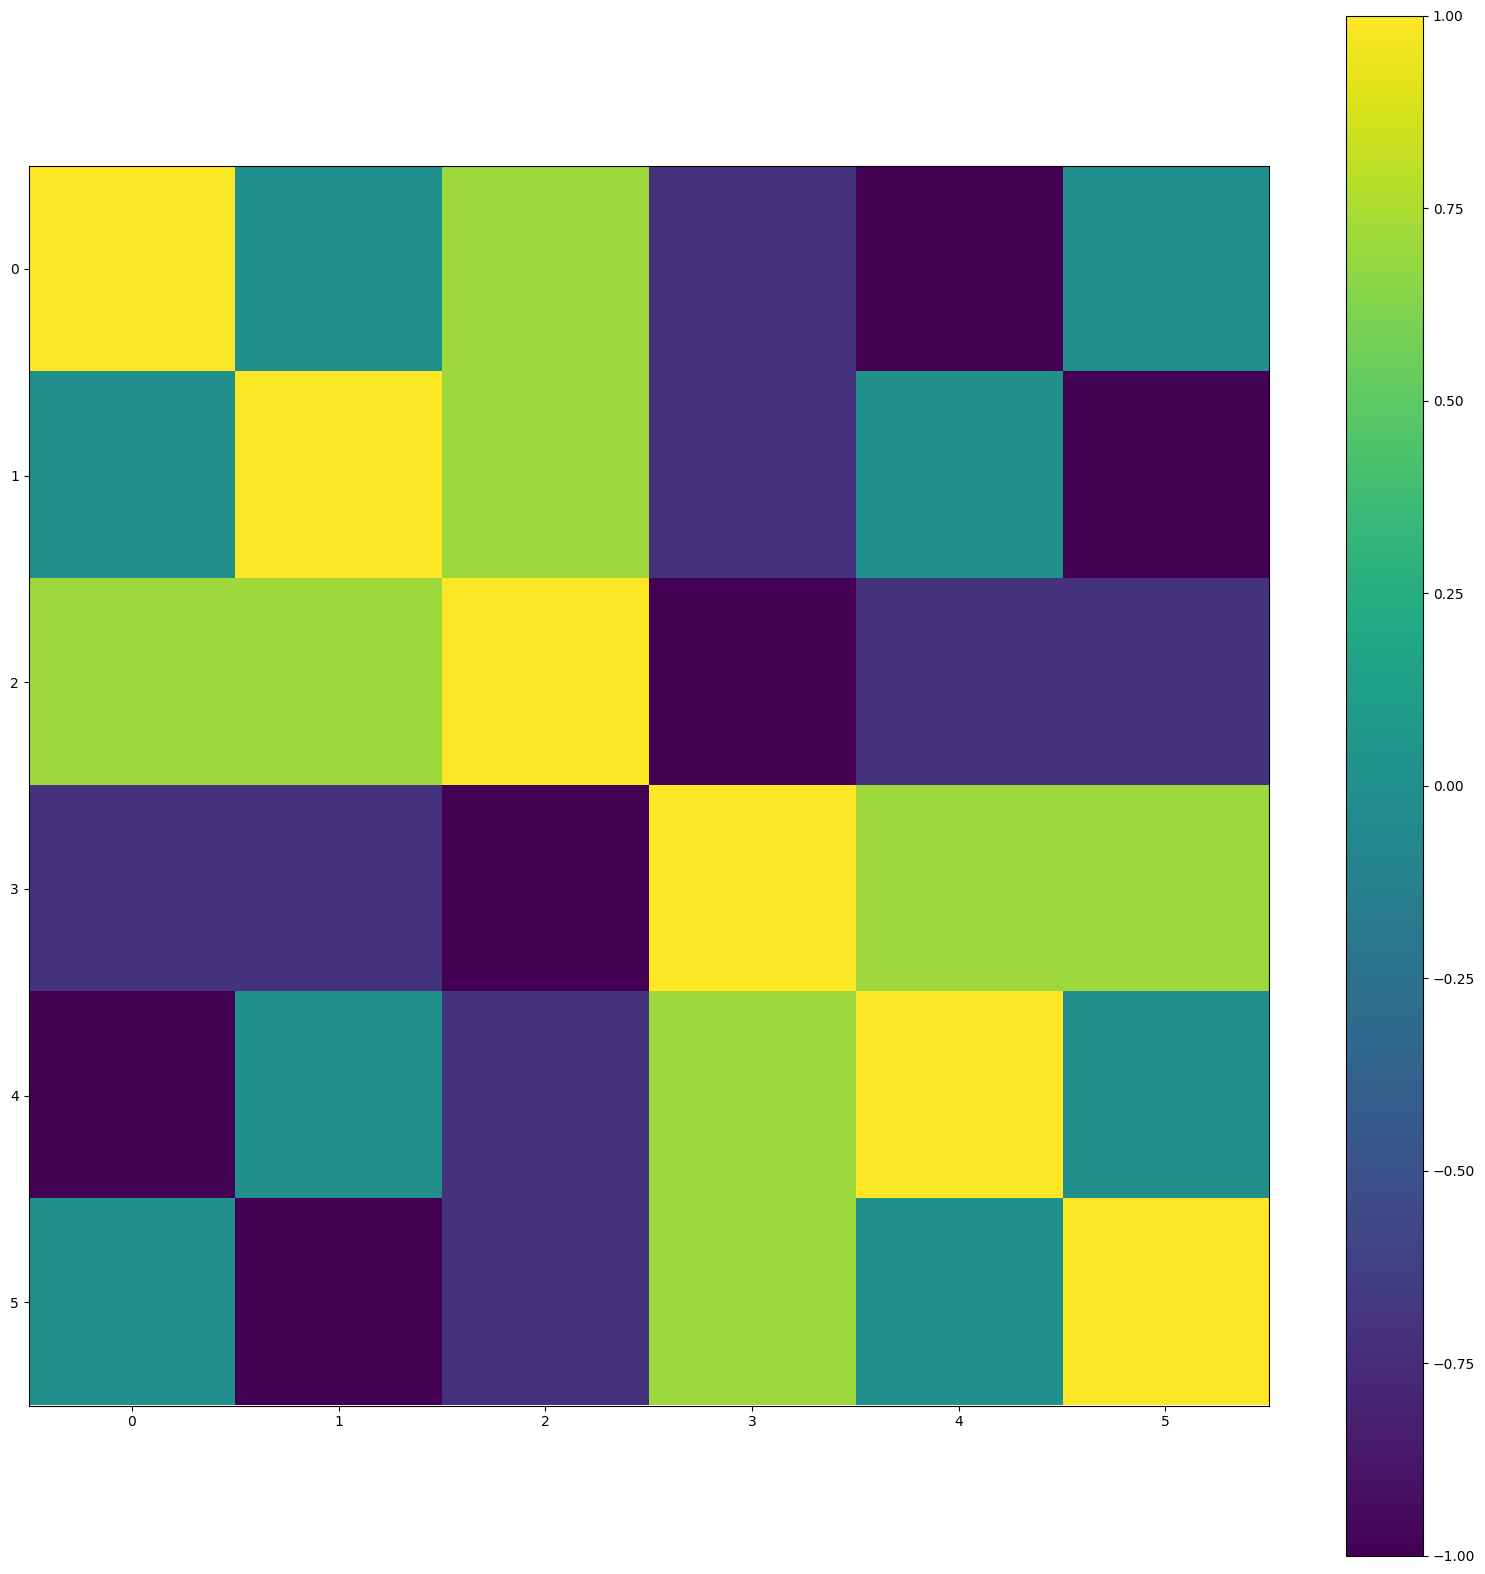

In [49]:
plt.figure(figsize=(20,20))
plt.imshow(sim)
plt.colorbar()

In [43]:
norm_query = query / query.norm(dim=1, keepdim=True)
sim = norm_query.matmul(norm_query.T)
sim.shape

torch.Size([6, 6])

In [27]:
sim.max(),sim.min()

(tensor(1.0000), tensor(0.4306))

In [45]:
def retrieve(gallery_features, query_features, batch_size, device=None):
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Epsilon value for numerical stability
    eps = 1e-6        


    # Type and dimension checks
    assert isinstance(gallery_features, (list, torch.Tensor, np.ndarray)), \
        "gallery_features must be a list, numpy array, or torch tensor."
    
    assert isinstance(query_features, (list, torch.Tensor, np.ndarray)), \
        "query_features must be a list, numpy array, or torch tensor."

    if isinstance(gallery_features, list):
        gallery_features = np.array(gallery_features)
    if isinstance(query_features, list):
        query_features = np.array(query_features)

    assert gallery_features.ndim == 2, "gallery_features must be a 2D array."
    assert query_features.ndim == 2, "query_features must be a 2D array."

    # Check for empty inputs
    assert len(gallery_features) > 0, "gallery_features is empty."
    assert len(query_features) > 0, "query_features is empty."



    # Move tensors to the specified device
    gallery_features = gallery_features.to(device) if isinstance(gallery_features, torch.Tensor) \
        else torch.tensor(gallery_features).to(device)
    
    query_features = query_features.to(device) if isinstance(query_features, torch.Tensor) \
        else torch.tensor(query_features).to(device)



    # Normalize the features
    query_norm = torch.nn.functional.normalize(query_features, p=2, dim=1, eps=eps)
    gallery_norm = torch.nn.functional.normalize(gallery_features, p=2, dim=1, eps=eps)


    # Calculate the similarity matrix
    similarity_matrix = torch.matmul(query_norm, gallery_norm.T)        

    # Sort the similarity matrix row-wise (descending order) and get original indices
    sorted_similarity_matrix, sorted_indices = torch.sort(similarity_matrix, descending=True, dim=1)

    return similarity_matrix, sorted_similarity_matrix, sorted_indices



# ##############################################################################
similarity_matrix, sorted_similarity_matrix, sorted_indices = retrieve(query, query, batch_size, device="cpu")

In [46]:
from torchmetrics.retrieval import RetrievalMAP


def calculate_map_torchmetrics(similarity_matrix, sorted_similarity_matrix, sorted_indices, gallery_labels, query_labels):
    # Assertions to ensure input validity
    assert isinstance(similarity_matrix, torch.Tensor), "similarity_matrix must be a torch.Tensor"
    assert isinstance(sorted_similarity_matrix, torch.Tensor), "sorted_similarity_matrix must be a torch.Tensor"
    assert isinstance(gallery_labels, torch.Tensor), "gallery_labels must be a torch.Tensor"
    assert isinstance(query_labels, torch.Tensor), "query_labels must be a torch.Tensor"
    assert similarity_matrix.dim() == 2, "similarity_matrix must be a 2D tensor"
    assert sorted_similarity_matrix.dim() == 2, "sorted_similarity_matrix must be a 2D tensor"
    assert similarity_matrix.shape == sorted_similarity_matrix.shape, "similarity_matrix and sorted_similarity_matrix must have the same shape"
    try:
        num_queries = similarity_matrix.shape[0]
        num_gallery_items = similarity_matrix.shape[1]

        # Prepare the indexes tensor. Each query gets a unique index.
        indexes = torch.arange(num_queries).unsqueeze(1).expand(-1, num_gallery_items)

        # Create binary ground truth tensor for each query-gallery pair
        expanded_query_labels = query_labels.unsqueeze(1).expand(-1, num_gallery_items)  # Reshape for broadcasting
        expanded_gallery_labels = gallery_labels.unsqueeze(0).expand(num_queries, -1)  # Reshape for broadcasting
        # ground_truths = (query_labels == gallery_labels).int()
        ground_truths = (expanded_query_labels == expanded_gallery_labels).int()

        print(f"####"*30)
        print(f"sum of the first row of ground truths: {ground_truths[0].sum()}")
        print(f"expanded_query_labels.shape: {expanded_query_labels.shape}")
        # print(f"First 10 elements of expanded_query_labels: {expanded_query_labels[:10]}")
        print(f"expanded_gallery_labels.shape: {expanded_gallery_labels.shape}")
        # print(f"First 10 elements of expanded_gallery_labels: {expanded_gallery_labels[:10]}")
        print(f"ground_truths.shape: {ground_truths.shape}")
        print(f"First 10 elements of ground_truths: {ground_truths[:10][0]}")
        print(f"sorted_similarity_matrix.shape: {sorted_similarity_matrix.shape}")
        # print(f"First 10 elements of sorted_similarity_matrix: {sorted_similarity_matrix[:10]}")
        print(f"sorted_indices.shape: {sorted_indices.shape}")
        print(f"indexes.shape: {indexes.shape}")
        # print(f"First 10 elements of indexes: {indexes[:10]}")
        print(f"####"*30)

        # Initialize the RetrievalMAP metric
        retrieval_map_metric = RetrievalMAP()

        # Calculate mAP
        # map_score = retrieval_map_metric(sorted_similarity_matrix, ground_truths, indexes)#.compute()
        map_score = retrieval_map_metric(sorted_similarity_matrix, ground_truths, sorted_indices)#.compute()

        return map_score
        
    except Exception as e:
        raise RuntimeError("Error in computing mAP: " + str(e))

map = calculate_map_torchmetrics(similarity_matrix, sorted_similarity_matrix, sorted_indices, label, label)


########################################################################################################################
sum of the first row of ground truths: 3
expanded_query_labels.shape: torch.Size([6, 6])
expanded_gallery_labels.shape: torch.Size([6, 6])
ground_truths.shape: torch.Size([6, 6])
First 10 elements of ground_truths: tensor([1, 1, 1, 0, 0, 0], dtype=torch.int32)
sorted_similarity_matrix.shape: torch.Size([6, 6])
sorted_indices.shape: torch.Size([6, 6])
indexes.shape: torch.Size([6, 6])
########################################################################################################################


In [47]:
map

tensor(0.5561)